# 최적 정규화

회귀 모형에서 모형 구조나 하이퍼 파라미터 등을 바꾸면 모형의 성능이 달라진다. 따라서 최적의 성능을 가져올 수 있는 모형 구조나 하이퍼 파라미터를 선택하는 과정이 필요하다.

## 다항 회귀의 차수 결정

다항회귀에서 차수를 바꾸어가면서 오차와 분산을 측정하면 다음과 같다.

In [1]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import cross_val_score

n_samples = 1000
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
y = np.cos(1.5 * np.pi * X) + np.random.randn(n_samples) * 0.1
X = X[:, np.newaxis]
K = 100

def cv_mse(degree):
    polynomial_features = PolynomialFeatures(degree=degree)
    linear_regression = LinearRegression()
    model = Pipeline([("polynomial_features", polynomial_features),
                      ("linear_regression", linear_regression)])
    scores = -cross_val_score(model, X, y, "mean_squared_error", cv=K)
    return scores

0.0130824469849 0.00760649444156


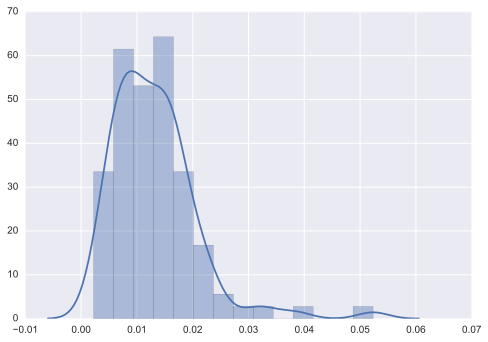

In [2]:
scores1 = cv_mse(3)
sns.distplot(scores1)
print(scores1.mean(), scores1.std())

In [3]:
D = 9
degrees = 2**np.arange(D)
all_scores = np.zeros((K, D))
for i, d in enumerate(degrees):
    scores = cv_mse(d)
    all_scores[:, i] = scores
df = pd.DataFrame(-np.log(all_scores), columns=degrees)
df.describe()

1           2           4           8           16          32   \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     2.152711    3.431163    4.735579    4.757005    4.746504    4.656334   
std      1.197341    0.801431    0.470647    0.464274    0.481903    0.741277   
min     -0.143751    1.023711    3.757597    3.746899    3.703366   -0.856989   
25%      1.283354    2.877161    4.449526    4.447033    4.426598    4.389030   
50%      1.912740    3.341536    4.659961    4.698884    4.686885    4.672894   
75%      2.922163    3.963974    5.023880    5.012029    5.031434    5.031744   
max      5.195028    5.061568    6.386555    6.284238    6.139297    6.340837   

              64          128         256  
count  100.000000  100.000000  100.000000  
mean     4.578126    4.507848    4.444991  
std      1.294590    1.813449    2.603389  
min     -6.695302  -12.463647  -20.834766  
25%      4.313580    4.295753    4.363543  
50%      4.702908    4.668740    4.663889  
75%      5.020715    5.042753    5.012505  
max      6.614761    6.549506    6.390193

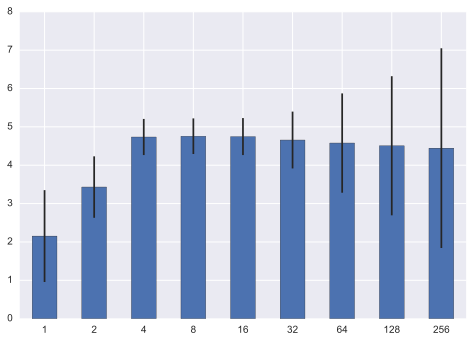

In [4]:
df.mean().plot(kind="bar", rot=0, yerr=df.std())
plt.show()

## 정규화 하이퍼 모수 최적화

정규화 모형에서 하이퍼 모수가 바뀌는 경우에도 마찬가지로 최적의 하이퍼 모수를 찾는 작업이 필요하다.

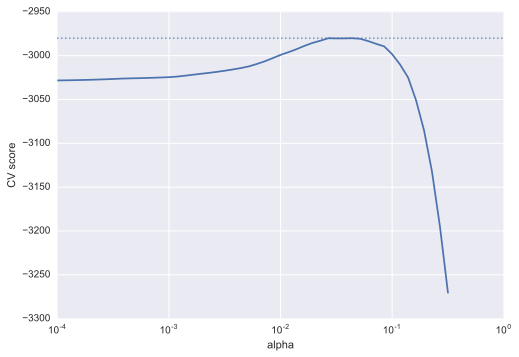

In [5]:
from sklearn.datasets import load_diabetes
from sklearn.linear_model import Lasso
from sklearn.cross_validation import cross_val_score

data = load_diabetes()
X = data.data[:200]
y = data.target[:200]

model = Lasso()
alphas = np.logspace(-4, -.5, 50)

scores = list()

for alpha in alphas:
    model.alpha = alpha
    this_scores = cross_val_score(model, X, y, "mean_squared_error", cv=5)
    scores.append(np.mean(this_scores))

plt.semilogx(alphas, scores)
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle=':')
plt.show()

0.0439397056076


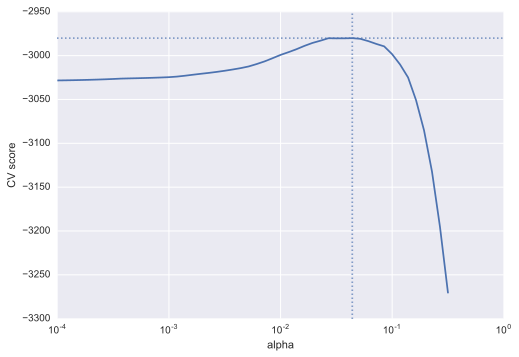

In [6]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, -.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

print(lasso_cv.alpha_ )

scores = -lasso_cv.mse_path_.mean(axis=1)
plt.semilogx(lasso_cv.alphas_, scores)
plt.axhline(np.max(scores), linestyle=':')    
plt.axvline(lasso_cv.alpha_ , linestyle=':')   
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()

## One Standard Error Rule

성능 오차를 고려해서 어느 정도 오차는 감수하더라도 더 단순한(정규화 모형에서는 더 제약 조건이 강한) 모형을 선택하는 것이 실용적이다. 예를 들어 One Standard Error Rule 은 최적 모형상에서 교차 검증을 통해 성능 오차의 분산값을 구하고 이 값 정도의 성능 감소가 있더라도 최적 모형보다 더 단순하거나 제약조건이 더 강한 모형을 선택한다.

0.117876863479


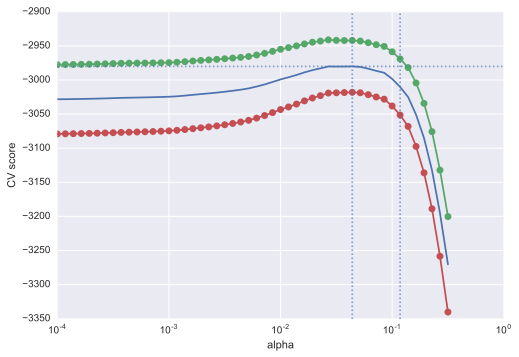

In [7]:
from sklearn.linear_model import LassoCV

alphas = np.logspace(-4, -.5, 50)
lasso_cv = LassoCV(alphas=alphas, cv=5)
lasso_cv.fit(X, y)

scores = -lasso_cv.mse_path_.mean(axis=1)
scores_std = lasso_cv.mse_path_.std(axis=1)
scores_std1 = scores + scores_std / np.sqrt(len(lasso_cv.mse_path_))
scores_std2 = scores - scores_std / np.sqrt(len(lasso_cv.mse_path_))

alpha_1se = lasso_cv.alphas_[np.argmax(scores_std1 > np.max(scores))]
print(alpha_1se)

plt.semilogx(lasso_cv.alphas_, scores)
plt.semilogx(lasso_cv.alphas_, scores_std1, 'o-')
plt.semilogx(lasso_cv.alphas_, scores_std2, 'o-')
plt.axhline(np.max(scores), linestyle=':')    
plt.axvline(lasso_cv.alpha_ , linestyle=':')   
plt.axvline(alpha_1se, linestyle=':')   
plt.ylabel('CV score')
plt.xlabel('alpha')
plt.show()